In [2]:
import cv2
from matplotlib import pyplot as plt 
import numpy as np



def KmeansSeg(image,K):
    
    Z = image.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1.0)
    
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_PP_CENTERS)
    #print(ret)
    #print(label)
    #print(center)
    
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((image.shape))
    
    return res2,ret,label,center


#Image processing tools

def GetImageFromFileCV(filename):
    image = cv2.imread(filename)
    return image    



def ResizeImgCV(image,size):
    image = np.asarray(cv2.resize(image,size))
    return image  

def PltImg(image):
    plt.imshow(image)
    plt.show()

def ColorDistribution2(image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        modified_img = image.reshape(image.shape[0]*image.shape[1], 3)
        hexcolorlist=[]
        for i in range(len(modified_img)):
            hexcolorlist.append(rgb_to_hex(modified_img[i]))

        unique,counts=np.unique(hexcolorlist,return_counts=True)

        return (unique,counts)

def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        num = int(i)
        #hex_color += ("{:02x}".format(i))
        hex_color += str(hex(num))[-2:].replace("x","0").upper()
    return hex_color




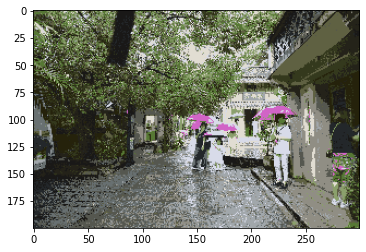

<BarContainer object of 26 artists>

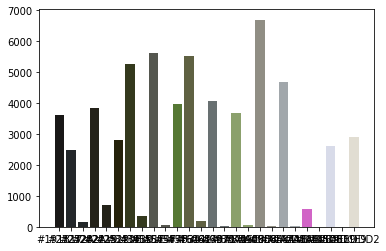

In [88]:
#-------------------------------------------------HSV method ----------------------------------------------

image = GetImageFromFileCV("E:\\Downloads\\gluonCV\\test\\2L7A0030.JPG")
image = ResizeImgCV(image,(300,200))

image=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)

#bgr to rgb

(res2,_,_,_)=KmeansSeg(image,15)

res2=cv2.cvtColor(res2,cv2.COLOR_HSV2BGR)

PltImg(res2[:,:,::-1])

#plot graph
res2 = res2
(unique,counts)=ColorDistribution2(res2)
plt.figure(figsize = (6, 4))
plt.bar(unique,counts,color = unique)

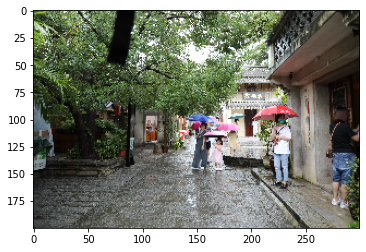

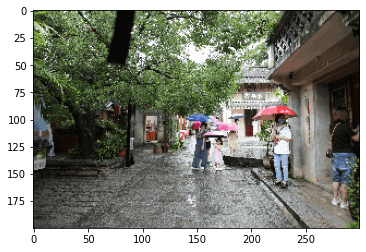

<BarContainer object of 100 artists>

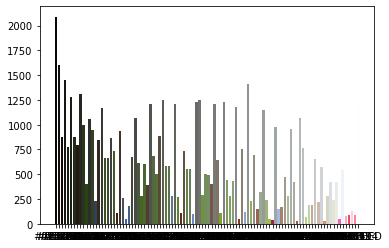

In [122]:
#-------------------------------------------------RGBMethod----------------------------------------------

image = GetImageFromFileCV("E:\\Downloads\\gluonCV\\test\\2L7A0030.JPG")
image = ResizeImgCV(image,(300,200))


#bgr to rgb
image=image[:,:,::-1]
(res2,_,_,_)=KmeansSeg(image,100)


PltImg(image)
PltImg(res2)

#plot graph
res2 = res2[:,:,::-1]
(unique,counts)=ColorDistribution2(res2)
plt.figure(figsize = (6, 4))
plt.bar(unique,counts,color = unique)

In [120]:
#-------------------------------------------------Multi-Iteration Method----------------------------------------------
def test1():
    image = GetImageFromFileCV("E:\\Downloads\\gluonCV\\test\\2L7A0030.JPG")
    image = ResizeImgCV(image,(300,200))
    K=15
    Start=K*8
    Klist=[100]
    #bgr to rgb
    image=image[:,:,::-1]
    #1st kmeans
    PltImg(image)

    #reshape 
   
    result = image.reshape(-1,3)
    i = Start
    for i in Klist:
        #kmeans
        (result,_,_,_)=KmeansSeg(result,i)
        #unique
        #result=np.unique(result,axis=0)
        #print("------------------"+ str(i) +"------------------------")



    result=result.reshape(1,-1,3)

    """
    plt.figure(figsize = (6, 4))
    a=np.array([10]*result.shape[0])
    plt.bar(result,a,color = result)
    """

    #PltImg(image)

    #plot graph

    (unique,counts)=ColorDistribution2(result)
    plt.figure(figsize = (6, 4))
    plt.bar(unique,counts,color = unique)

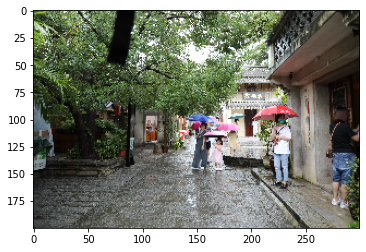

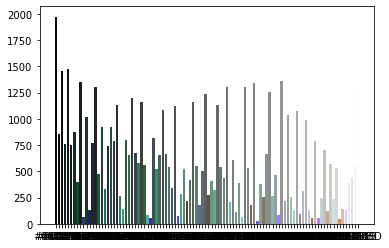

In [121]:
for i in range(1,2):
    test1()